# Project 3 Solutions

In this project, you will perform a logistic regression on the admissions data we've worked with previously in projects 1 and 2

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

%matplotlib inline

In [5]:
df_raw = pd.read_csv("./datasets/admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables ([hint](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.crosstab.html))

In [6]:
# frequency table for prestige and whether or not someone was admitted
print(pd.crosstab(df['admit'], df['prestige'], rownames=['admit']))

prestige  1.0  2.0  3.0  4.0
admit                       
0          28   95   93   55
1          33   53   28   12


In [7]:
# we can make this more intuitive by changing counts to percentages
print(pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])/len(df))

prestige       1.0       2.0       3.0       4.0
admit                                           
0         0.070529  0.239295  0.234257  0.138539
1         0.083123  0.133501  0.070529  0.030227


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [8]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print(dummy_ranks.head())

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             0             0             1             0
1             0             0             1             0
2             1             0             0             0
3             0             0             0             1
4             0             0             0             1


#### 2.2 When modeling our class variables, how many do we need? (caution: be sure to avoid the dreaded [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html))  
All 4? 3? 2? 1? 

> **Answer**: we use a set of n-1 dummy variables to represent an n‑category variable

#### Why?? 
This is done to prevent [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity#Remedies_for_multicollinearity), or the [dummy variable trap](http://bit.ly/1L8y73a) caused by including a dummy variable for every single category.

## Part 3. Hand calculating [odds ratios](https://lifeinthefastlane.com/ccc/odds-ratio/)

Develop your intuition about expected outcomes by hand calculating odds ratios

In [9]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.loc[:, 'prestige_1':])
print(handCalc.head())

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             0             1             0
1      1  660.0  3.67             0             0             1             0
2      1  800.0  4.00             1             0             0             0
3      1  640.0  3.19             0             0             0             1
4      0  520.0  2.93             0             0             0             1


In [10]:
# make a frequency table cutting 'prestige_1.0' and whether or not someone was admitted
print(pd.crosstab(handCalc['admit'], handCalc['prestige_1.0'], rownames=['admit']))

prestige_1.0    0   1
admit                
0             243  28
1              93  33


#### 3.1 Use the values from the [cross tab](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.crosstab.html) produced above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [11]:
odds_exposed = 33/28.0
print(odds_exposed)

1.17857142857


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [12]:
odd_unexp = 93/243.0
print(odd_unexp)

0.382716049383


#### 3.3 Use 3.1 and 3.2 to calculate the odds ratio (OR)

In [13]:
OR = odds_exposed/odd_unexp
print(OR)

3.07949308756


#### 3.4 Write this finding in a sentence: 

For students who attended a top ranked college, the odds of being admitted into graduate school are 3.07 times the odds of students who did not attend a top tier school. 

The odds of being admitted to graduate school are over 2 times higher for students who attended a top ranked school compared to students who did not. 

#### 3.5 Print the cross tab for 'prestige_4.0'

In [14]:
print(pd.crosstab(handCalc['admit'], handCalc['prestige_4.0'], rownames=['admit']))

prestige_4.0    0   1
admit                
0             216  55
1             114  12


#### 3.6 Calculate the OR 

In [15]:
OR_1 = (12.0/55)/(114.0/216) # these are equivalent
OR_2 = (12.0*216)/(114.0*55)
print(OR_1,OR_2)

(0.4133971291866028, 0.4133971291866029)


#### 3.7 Write this finding in a sentence

For students who attended a 4th tier school the odds of being admitted into graduate school are 0.41 times the odds of students who did not attend a 4th tier school. 

## Part 4. Analysis

Set 1 (aka most prestigious) as your reference category and merge prestige_2, prestige_3 and prestige_4 back into the dataset. 

#### Reminder- How to use dummy variables to represent an n-category variable:
1. First note that we use a set of n-1 dummy variables to represent an n‑category variable.
2. Choose one of the categories to serve as the “reference” category, the category to which you compare the other categories.
3. Create dummy (0/1) variables to represent each of the other categories.  Each dummy is coded so that it has the value 1 if a case is in that category, and 0 if not.
4. Interpret the regression coefficient for each dummy variable as how that category compares to the reference category.

In [16]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.loc[:, 'prestige_2':])
print(data.head())

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


We're going to add a constant term for our Logistic Regression
- The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly

In [17]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Define the labels of the covariates (columns) as a variable called 'train_cols'

In [18]:
data.columns

Index([u'admit', u'gre', u'gpa', u'prestige_2.0', u'prestige_3.0',
       u'prestige_4.0', u'intercept'],
      dtype='object')

In [19]:
train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

#### 4.2 Fit the model

In [20]:
logit = sm.Logit(data['admit'], data[train_cols])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [21]:
print(result.summary2())

                        Results: Logit
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: admit            Pseudo R-squared: 0.082   
Date:               2018-04-24 18:54 AIC:              467.6399
No. Observations:   397              BIC:              491.5435
Df Model:           5                Log-Likelihood:   -227.82 
Df Residuals:       391              LL-Null:          -248.08 
Converged:          1.0000           Scale:            1.0000  
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
gre              0.0022   0.0011  2.0280 0.0426  0.0001  0.0044
gpa              0.7793   0.3325  2.3438 0.0191  0.1276  1.4311
prestige_2.0    -0.6801   0.3169 -2.1459 0.0319 -1.3013 -0.0589
prestige_3.0    -1.3387   0.3449 -3.8819 0.0001 -2.0146 -0.6628
prestige_4.0    -1.5534   0.4175 -3.7211 0.0002 -2.3716 -0.7352
i

#### 4.4 Calculate the odds ratio of the coefficients and their 95% [confidence intervals](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.LogitResults.conf_int.html)

hints: 
```python        
        np.exp(X)

        conf['OR'] = params
        
        conf.columns = ['2.5%', '97.5%', 'OR']
```

In [22]:
params = result.params # get coefficients
print(np.exp(params)) # odds ratio of the coefficients

gre             1.002221
gpa             2.180027
prestige_2.0    0.506548
prestige_3.0    0.262192
prestige_4.0    0.211525
intercept       0.020716
dtype: float64


In [23]:
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print(np.exp(conf)) # confidence intervals (we get the odds ratio from the log odds by exponentiating the coefficient)

                  2.5%     97.5%        OR
gre           1.000074  1.004372  1.002221
gpa           1.136120  4.183113  2.180027
prestige_2.0  0.272168  0.942767  0.506548
prestige_3.0  0.133377  0.515419  0.262192
prestige_4.0  0.093329  0.479411  0.211525
intercept     0.002207  0.194440  0.020716


#### 4.5 [Interpret](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) the OR of Prestige_2

Answer: Students who attended a tier 2 undergraduate school had 0.50 the odds of being admitted to graduate school compared to students who attend a tier 1 undergraduate school. 

#### 4.6 Interpret the OR of GPA

Answer: For a one-unit increase in the 'gpa' score, the expected change in odds is 2.180027.

## Part 5. Predicted probablities

As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified minimum and maximum value--in our case just the min/max observed values.

In [24]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    print(n,arrays[0].size)
    print('m =',m)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [25]:
cartesian(([1, 2, 3], [4, 5], [6, 7]))

(12, 3)
('m =', 4)
(4, 2)
('m =', 2)
(2, 2)
('m =', 1)


array([[1, 4, 6],
       [1, 4, 7],
       [1, 5, 6],
       [1, 5, 7],
       [2, 4, 6],
       [2, 4, 7],
       [2, 5, 6],
       [2, 5, 7],
       [3, 4, 6],
       [3, 4, 7],
       [3, 5, 6],
       [3, 5, 7]])

In [26]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print(gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print(gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])

# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[220.         284.44444444 348.88888889 413.33333333 477.77777778
 542.22222222 606.66666667 671.11111111 735.55555556 800.        ]
[2.26       2.45333333 2.64666667 2.84       3.03333333 3.22666667
 3.42       3.61333333 3.80666667 4.        ]
(400, 10)
('m =', 40)
(40, 10)
('m =', 4)
(4, 4)
('m =', 1)
(1, 1)
('m =', 1)


#### 5.1 Re-create the dummy variables

In [27]:
# re-create the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.loc[:, 'prestige_2.0':])

#### 5.2 Make predictions on the enumerated dataset using the model we created previously
e.g.
```python
result.predict(combos[train_cols])
```

In [28]:
combos['admit_pred'] = result.predict(combos[train_cols])

print(combos.tail())

       gre       gpa  prestige  intercept  prestige_2.0  prestige_3.0  \
395  800.0  3.806667       4.0        1.0             0             0   
396  800.0  4.000000       1.0        1.0             0             0   
397  800.0  4.000000       2.0        1.0             1             0   
398  800.0  4.000000       3.0        1.0             0             1   
399  800.0  4.000000       4.0        1.0             0             0   

     prestige_4.0  admit_pred  
395             1    0.334286  
396             0    0.734040  
397             0    0.582995  
398             0    0.419833  
399             1    0.368608  


#### 5.3 Interpret findings for the last 4 observations

Answer: Given the same GPA and GRE scores, students who attended a tier 4 undergraduate school had a 37% probability of being admitted into grad school, while student who attended a tier 1 school had a 73% likelihood of being admitted into grad school.

## Bonus!

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

                     admit_pred
gre        prestige            
220.000000 1.0         0.287000
           2.0         0.172354
           3.0         0.098493
           4.0         0.081236
284.444444 1.0         0.315963
           2.0         0.193117
           3.0         0.111697
           4.0         0.092395
348.888889 1.0         0.346366
           2.0         0.215673
           3.0         0.126392
           4.0         0.104888
413.333333 1.0         0.378022
           2.0         0.240018
           3.0         0.142674
           4.0         0.118822
477.777778 1.0         0.410706
           2.0         0.266115
           3.0         0.160626
           4.0         0.134297
542.222222 1.0         0.444161
           2.0         0.293885
           3.0         0.180314
           4.0         0.151401
606.666667 1.0         0.478106
           2.0         0.323213
           3.0         0.201782
           4.0         0.170211
671.111111 1.0         0.512246
        

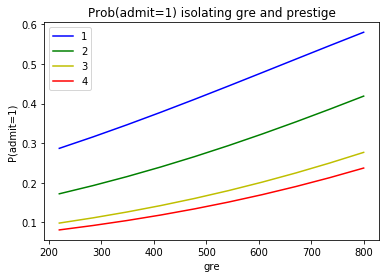

                   admit_pred
gpa      prestige            
2.260000 1.0         0.279423
         2.0         0.166760
         3.0         0.094879
         4.0         0.078172
2.453333 1.0         0.309664
         2.0         0.188216
         3.0         0.108417
         4.0         0.089590
2.646667 1.0         0.341563
         2.0         0.211674
         3.0         0.123592
         4.0         0.102468
2.840000 1.0         0.374905
         2.0         0.237141
         3.0         0.140522
         4.0         0.116932
3.033333 1.0         0.409428
         2.0         0.264579
         3.0         0.159307
         4.0         0.133103
3.226667 1.0         0.444831
         2.0         0.293901
         3.0         0.180030
         4.0         0.151088
3.420000 1.0         0.480780
         2.0         0.324971
         3.0         0.202744
         4.0         0.170978
3.613333 1.0         0.516920
         2.0         0.357601
         3.0         0.227468
         4

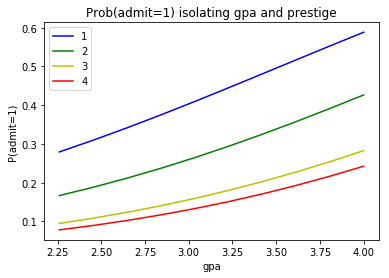

In [29]:
def isolate_and_plot(variable):
    """ 
    Isolate gre and class rank 
    
    Example:
    #                      admit_pred
    # gre        prestige            
    # 220.000000 1           0.282462
    #            2           0.169987
    #            3           0.096544
    #            4           0.079859
    # 284.444444 1           0.311718
    """
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable,'prestige'], aggfunc=np.mean)
    print(grouped)
    
    # make a plot
    colors = 'rbgyrbgy'
    for i,col in enumerate(combos.prestige.unique()):
        plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
        plt.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)], label=str(i+1))

    plt.xlabel(variable)
    plt.ylabel("P(admit=1)")
    plt.legend()
    plt.title("Prob(admit=1) isolating " + variable + " and prestige")
    plt.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')

##### inspired by the great blog post: http://blog.yhathq.com/posts/logistic-regression-and-python.html  